# **3: DuckDB's Best Practices**

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

Source: 
- [Getting Started with DuckDB](https://www.packtpub.com/en-ar/product/getting-started-with-duckdb-9781803232539) by Simon Aubury & Ned Letcher
- [DuckDB documentation](https://duckdb.org/docs/)
---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/DuckDB/notebooks/2_duckdb_python_API.ipynb).

---

This is part 3 of the series of notebooks on DuckDB.  
In the previous two notebooks I've introduced DuckDB and showed how to load, transform and briefly analyse data from different sources.  

Here I will learn about best practices that:
- save time when:
  - [querying](#select-) or [inserting](#insert) data to a DuckDB database
  - joining tables ([positional](#positional-joins) and [temporal joins](#temporal-joins-asof))

For an introduction to DuckDB, check [my first notebook](https://github.com/jendives2000/Data_ML_Practice_2025/blob/82571ad44176666f9cf0735c5141c6a96d5eace9/1-3-SQL/practice/DuckDB/notebooks/1_duckdb_intro.ipynb). I also say in there when you should not use DuckDB. 
For understanding how DuckDB works, check my [second notebook](https://github.com/jendives2000/Data_ML_Practice_2025/blob/ef8533ad82586234cfdc54a494c0c5be590816cc/1-3-SQL/practice/DuckDB/notebooks/2_duckdb_python_API.ipynb).

**OUTLINE:**  
In more details, I will cover the followings:
- [**Selecting columns**](#select-) effectively
- Applying [**function chaining**](#function-chaining)
- Using [**INSERT**](#insert) effectively
- Leveraging [**positional** joins](#positional-joins) and [**temporal joins**](#temporal-joins-asof)
- [**Recursive** queries](#hierarchical-traversal) and [macros](#macros)
- additional **tips and tricks**

**NICETIES:**  
Some of the nicest little thing are: 
- [trailing comma](#trailing-comma-is-fine) not a problem
- the [exclude](#exclude-columns) clause
- [visual bars](#visualize-bars-in-the-output) in the output
- [insert or replace](#insert-or-replace)

**SKIERS DATABASE**:  
I added several very simple Skiers Database and csv files in the data/data_in folder: `skiers.csv`  
They'll be used throughout this notebook. 

**The main takeaway is**:
- to **better comprehend** the **differences** between regular SQL queries and DuckDB enhanced queries, which is often a lot less verbosity and more readability. 

---


## Imports:

In [1]:
# Add parent directory to sys.path
#sys.path.append(os.path.abspath(".."))
#from utils.duckdb_shared_code import

### **Table setup using the DuckDB Shell**:

I want to work with the DuckDB shell, from my Jupyter notebook. It is possible by using the following syntax:

In [2]:
!duckdb ../databases/mydatabase.duckdb -c "create or replace table skiers as select * from read_csv('../data/data_in/skiers.csv');"

In [3]:
!duckdb ../databases/mydatabase.duckdb -c "show tables"

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ skiers  │
└─────────┘


Let's refactor this syntax and copy it over to the `duckdb_shared_code.py` file. 

In [4]:
def shell_commd(stmt):
    # Collapse all whitespace (including newlines) into single spaces
    cleaned_stmt = " ".join(stmt.split())
    get_ipython().system(f"duckdb ../databases/mydatabase.duckdb -c \"{cleaned_stmt}\"")

---

## **`select *`**:
I want to see the whole table skiers now:

In [5]:
shell_commd(
    """
    select * 
    from skiers
    ;
    """
)

┌──────────────────┬─────────────────┬───────────┬──────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_last_name │ skier_age │ skier_height │ skier_helmet_color │ skier_bib_color │
│     varchar      │     varchar     │   int64   │    int64     │      varchar       │     varchar     │
├──────────────────┼─────────────────┼───────────┼──────────────┼────────────────────┼─────────────────┤
│ Alice            │ Smith           │        12 │          152 │ red                │ black           │
│ Bob              │ Blaese          │        16 │          178 │ blue               │ yellow          │
│ Carol            │ Wilson          │        32 │          159 │ yellow             │ pink            │
│ Dan              │ Jones           │        52 │          182 │ red                │ yellow          │
│ Erin             │ Taylor          │        22 │          168 │ black              │ green           │
│ Frank            │ Williams        │        18 │     

### Trailing comma is fine:  
One little improvement that I appreciate is that a final trailing comma is not throwing an error.  
I select multiple columns, and I forget to remove my last comma here `skier_bib_color,`, line 9: 

In [6]:
shell_commd(
    """
    select
        skier_first_name,
        skier_last_name,
        skier_age,
        skier_height,
        skier_helmet_color,
        skier_bib_color,
    from skiers
    ;
    """
)

┌──────────────────┬─────────────────┬───────────┬──────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_last_name │ skier_age │ skier_height │ skier_helmet_color │ skier_bib_color │
│     varchar      │     varchar     │   int64   │    int64     │      varchar       │     varchar     │
├──────────────────┼─────────────────┼───────────┼──────────────┼────────────────────┼─────────────────┤
│ Alice            │ Smith           │        12 │          152 │ red                │ black           │
│ Bob              │ Blaese          │        16 │          178 │ blue               │ yellow          │
│ Carol            │ Wilson          │        32 │          159 │ yellow             │ pink            │
│ Dan              │ Jones           │        52 │          182 │ red                │ yellow          │
│ Erin             │ Taylor          │        22 │          168 │ black              │ green           │
│ Frank            │ Williams        │        18 │     

No problems, the last trailing comma is valid!

### **Exclude columns**: 

What if I need every column but one? Normally I'd have to select each single column except for the one I don't want.  
Now with EXCLUDE() I can just exclude the one column (or more) to get everything else. 

In [7]:
shell_commd(
    """
    select s.*
    exclude(skier_age, skier_height)
    from skiers as s
    ;
    """
)

┌──────────────────┬─────────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_last_name │ skier_helmet_color │ skier_bib_color │
│     varchar      │     varchar     │      varchar       │     varchar     │
├──────────────────┼─────────────────┼────────────────────┼─────────────────┤
│ Alice            │ Smith           │ red                │ black           │
│ Bob              │ Blaese          │ blue               │ yellow          │
│ Carol            │ Wilson          │ yellow             │ pink            │
│ Dan              │ Jones           │ red                │ yellow          │
│ Erin             │ Taylor          │ black              │ green           │
│ Frank            │ Williams        │ yellow             │ red             │
│ Grace            │ Miller          │ pink               │ black           │
│ Heidi            │ Johnson         │ yellow             │ yellow          │
│ Ivan             │ Brown           │ green              │ pink

### **Dynamic Column Replacement**: 

Let's say I now want to round the skier_age to the nearest 10 years and convert them into integers, effectively changing its value and data type. The method REPLACE() helps do that kind of modifications: 

In [8]:
shell_commd(
    """
    select s.*
        replace(
            round(skier_age / 10) *10
        )::integer 
        as skier_age
    from skiers as s
    ;
    """
)

┌──────────────────┬─────────────────┬───────────┬──────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_last_name │ skier_age │ skier_height │ skier_helmet_color │ skier_bib_color │
│     varchar      │     varchar     │   int32   │    int64     │      varchar       │     varchar     │
├──────────────────┼─────────────────┼───────────┼──────────────┼────────────────────┼─────────────────┤
│ Alice            │ Smith           │        10 │          152 │ red                │ black           │
│ Bob              │ Blaese          │        20 │          178 │ blue               │ yellow          │
│ Carol            │ Wilson          │        30 │          159 │ yellow             │ pink            │
│ Dan              │ Jones           │        50 │          182 │ red                │ yellow          │
│ Erin             │ Taylor          │        20 │          168 │ black              │ green           │
│ Frank            │ Williams        │        20 │     

### **Column Selector**:

I can also use the column selector COLUMNS() with a regular expression to, say, get columns that have the word 'color' in their name:  

In [9]:
shell_commd(
    """
    select 
        skier_first_name,
        columns(
            '.*color$'
        )
    from skiers
    ;
    """
)

┌──────────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_helmet_color │ skier_bib_color │
│     varchar      │      varchar       │     varchar     │
├──────────────────┼────────────────────┼─────────────────┤
│ Alice            │ red                │ black           │
│ Bob              │ blue               │ yellow          │
│ Carol            │ yellow             │ pink            │
│ Dan              │ red                │ yellow          │
│ Erin             │ black              │ green           │
│ Frank            │ yellow             │ red             │
│ Grace            │ pink               │ black           │
│ Heidi            │ yellow             │ yellow          │
│ Ivan             │ green              │ pink            │
│ Judy             │ red                │ black           │
├──────────────────┴────────────────────┴─────────────────┤
│ 10 rows                                       3 columns │
└───────────────────────────────────────

The regular expression `'.*color$'` matched 2 columns that have in their name the word color. 

I can take it one step further and filter it to get only one type of value from these columns, say the color yellow. 

In [10]:
shell_commd(
    """
    select 
        skier_first_name,
        columns(
            '.*color.*'
        )
    from skiers
    where columns('.*color.*') == 'yellow'
    ;
    """
)

┌──────────────────┬────────────────────┬─────────────────┐
│ skier_first_name │ skier_helmet_color │ skier_bib_color │
│     varchar      │      varchar       │     varchar     │
├──────────────────┼────────────────────┼─────────────────┤
│ Heidi            │ yellow             │ yellow          │
└──────────────────┴────────────────────┴─────────────────┘


---

## **Function Chaining**:

I showed a glimpse of that feature in my previous notebook. It adds **readability** and also, for Python users among you, **usability**. 

The little exercise I am doing is as follows: 
- putting together the first and last name of skiers with the **`CONCAT_WS()` method**
- make that full name in uppercase with **UPPER()**
- add a filler, '_' that will push the full name to right edge of its column width, and make that width 20 units, with **`LPAD()`**
- add a full stop '.' at the end

### **The naive way**:  

Let's see:

In [11]:
shell_commd(
    """
    select concat(
        lpad(
            upper(
                concat_ws(' ', skier_first_name, skier_last_name)
            ),
            20,
            '_'
        ),
        '.'
    )
    as skier_name
    from skiers
    ;
    """
)

┌───────────────────────┐
│      skier_name       │
│        varchar        │
├───────────────────────┤
│ _________ALICE SMITH. │
│ __________BOB BLAESE. │
│ ________CAROL WILSON. │
│ ___________DAN JONES. │
│ _________ERIN TAYLOR. │
│ ______FRANK WILLIAMS. │
│ ________GRACE MILLER. │
│ _______HEIDI JOHNSON. │
│ __________IVAN BROWN. │
│ __________JUDY MOORE. │
├───────────────────────┤
│        10 rows        │
└───────────────────────┘


Regardless of the way I laid out the code, this goes 3 indenting levels down, with hard to read text characters like '.' or '_'.  

**NOTE**:  
It is important to remember that that each function used here is what is called a scalar function. It returns only one value.  
Chaining **ONLY** works with **scalar** functions. More [here](https://duckdb.org/docs/sql/functions/overview.html) on DuckDB's website.

### **Correct way: method chaining**:
Now let's see one of the correct way, with of course method chaining: 

In [12]:
shell_commd(
    """
    select concat_ws(' ', skier_first_name, skier_last_name)
        .upper()
        .lpad(20, '_')
        .concat('.')
        as skier_name
    from skiers
    ;
    """
)

┌───────────────────────┐
│      skier_name       │
│        varchar        │
├───────────────────────┤
│ _________ALICE SMITH. │
│ __________BOB BLAESE. │
│ ________CAROL WILSON. │
│ ___________DAN JONES. │
│ _________ERIN TAYLOR. │
│ ______FRANK WILLIAMS. │
│ ________GRACE MILLER. │
│ _______HEIDI JOHNSON. │
│ __________IVAN BROWN. │
│ __________JUDY MOORE. │
├───────────────────────┤
│        10 rows        │
└───────────────────────┘


---

## **insert**:

As it is often needed, I want to have an index, here on the skiers, so that each skier's name is uniquelu identified if there is false duplicates (different persons but with the same full name)

In [15]:
shell_commd(
    """
    create unique index skier_unique
    on skiers (skier_first_name)
    ;
    """
)

Ok, let's say that a new skier is added: Kim with a blue helmet. 
Here's the naive approach to insert Kim:

In [20]:
shell_commd(
    """
    insert into skiers(
        skier_first_name, 
        skier_helmet_color
        )
    select 
        'Kim' as skier_first_name,
        'blue' as skier_helmet_color
    ;
    """
)

While this syntax is not complex, I have to respect the order of what is inserted with what is selected. For bigger inserts this can potentially become very taxing. 

### **by name**:
For that, I can use the `by name` directive. Let's use it to add Liam:

In [22]:
shell_commd(
    """
    insert into skiers by name
    select 
        'green' as skier_helmet_color,
        'red' as skier_bib_color,
        'Liam' as skier_first_name,
    ;
    """
)

Checking Liam's insert:

In [23]:
shell_commd(
    """
    select 
        skier_first_name as sfn,
        skier_helmet_color,
        skier_bib_color,
    from skiers
    where sfn = 'Liam'
    ;
    """
)

┌─────────┬────────────────────┬─────────────────┐
│   sfn   │ skier_helmet_color │ skier_bib_color │
│ varchar │      varchar       │     varchar     │
├─────────┼────────────────────┼─────────────────┤
│ Liam    │ green              │ red             │
└─────────┴────────────────────┴─────────────────┘


### **insert or replace**:

Liam just changed his helmet and it is now black. 
To update this, instead of manually checking for Liam's helmet row and changing it, I can just use the `insert or replace` clause. 

This avoids the need to use a `merge` or an `ON CONFLICT DO UPDATE`.

In [25]:
shell_commd(
    """
    insert or replace into skiers by name
    select
        'Liam' as skier_first_name,
        'black' as skier_helmet_color
    ;
    """
)

If i repeat the previous code I can see again Liam's details, updated: 

In [26]:
shell_commd(
    """
    select 
        skier_first_name as sfn,
        skier_helmet_color,
        skier_bib_color,
    from skiers
    where sfn = 'Liam'
    ;
    """
)

┌─────────┬────────────────────┬─────────────────┐
│   sfn   │ skier_helmet_color │ skier_bib_color │
│ varchar │      varchar       │     varchar     │
├─────────┼────────────────────┼─────────────────┤
│ Liam    │ black              │ red             │
└─────────┴────────────────────┴─────────────────┘


---

## **positional joins**:

A positional join is a feature in DuckDB that looks at the ordering of 2 or more tables, no matter how different these ordering are. 

For example, our skiers are competing. Each skier competes and their name is added at the end of a file (skiers.csv). The judges' scores are inserted in the skiers_scores.csv file, starting from the top of the file and down. 

I start by replacing the skiers table with the table from the skiers.csv file: 

In [28]:
shell_commd(
    """
    create or replace table skiers as
    select *
    from read_csv('../data/data_in/skiers.csv')
    ;    
    """
)

I imported the skiers' score file in the data/data_in folder. Let's create the score table from it: 

In [29]:
shell_commd(
    """
    create or replace table scores as
    select *
    from read_csv('../data/data_in/skier_scores.csv')
    ;   
    """
)

So without DuckDB, these 2 tables are seen as **unordered**. Which means that another element is needed to do the orders matching.  
DuckDB can see them as two dataframes and connects them with the `positional join` clause:

In [30]:
shell_commd(
    """
    select
        df_sk.skier_first_name,
        df_sk.skier_last_name,
        df_sc.score
    from skiers 
        as df_sk positional join scores as df_sc
    ;
    """
)

┌──────────────────┬─────────────────┬───────┐
│ skier_first_name │ skier_last_name │ score │
│     varchar      │     varchar     │ int64 │
├──────────────────┼─────────────────┼───────┤
│ Alice            │ Smith           │     8 │
│ Bob              │ Blaese          │     9 │
│ Carol            │ Wilson          │     4 │
│ Dan              │ Jones           │     7 │
│ Erin             │ Taylor          │     6 │
│ Frank            │ Williams        │     9 │
│ Grace            │ Miller          │     9 │
│ Heidi            │ Johnson         │     5 │
│ Ivan             │ Brown           │     7 │
│ Judy             │ Moore           │     8 │
├──────────────────┴─────────────────┴───────┤
│ 10 rows                          3 columns │
└────────────────────────────────────────────┘


---

## **temporal joins: ASOF**

To illustrate the use of ASOF we need some context. More data needs to be put together: 
- the wind speed
- the temperature
- at the time each skier got a score

I could join each skier's score_time to the measurement_time_timestamp BUT this will not work because they are both different. For example:  
- score time = 2023-12-01 10:01:28  
- measurement_time_timestamp = 2023-12-01 10:00:00  

The time measurement is hourly and automatic. Skiers' scores time are not automatic. 

#### **standard SQL way**:
Let's look at one of the way to do this using standard SQL.  
For that I imported the weather.csv file and I now need to create a table out of it:

In [32]:
shell_commd(
    """
    create or replace table weather as
    select *
    from read_csv(
        '../data/data_in/weather.csv',
        timestampformat='%Y-%m-%d %H:%M:%S'
        )
    ;
    """
)

In [33]:
shell_commd(
    """
    select *
    from weather
    limit 10
    ;
    """
)

┌─────────────────────┬────────────┬───────┐
│  measurement_time   │ wind_speed │ temp  │
│      timestamp      │   int64    │ int64 │
├─────────────────────┼────────────┼───────┤
│ 2023-12-01 10:00:00 │          7 │    -9 │
│ 2023-12-01 11:00:00 │         19 │    -8 │
│ 2023-12-01 12:00:00 │          8 │    -6 │
│ 2023-12-01 13:00:00 │          9 │    -3 │
│ 2023-12-01 14:00:00 │         10 │    -2 │
│ 2023-12-01 15:00:00 │         10 │    -2 │
│ 2023-12-01 16:00:00 │         12 │    -2 │
│ 2023-12-01 17:00:00 │         12 │    -3 │
│ 2023-12-01 18:00:00 │         12 │    -3 │
│ 2023-12-01 19:00:00 │         11 │    -4 │
├─────────────────────┴────────────┴───────┤
│ 10 rows                        3 columns │
└──────────────────────────────────────────┘


In [35]:
shell_commd(
    """
    with weather_cte as(
        select measurement_time,
        wind_speed, 
        temp,
        lead(measurement_time, 1)
            over (order by measurement_time) as measurement_end
        from weather
        order by measurement_time
    )
    select * 
    from weather_cte
    where timestamp '2023-12-01 10:01:00'
        between measurement_time and measurement_end
    ;
    """
)

┌─────────────────────┬────────────┬───────┬─────────────────────┐
│  measurement_time   │ wind_speed │ temp  │   measurement_end   │
│      timestamp      │   int64    │ int64 │      timestamp      │
├─────────────────────┼────────────┼───────┼─────────────────────┤
│ 2023-12-01 10:00:00 │          7 │    -9 │ 2023-12-01 11:00:00 │
└─────────────────────┴────────────┴───────┴─────────────────────┘


There's a lot happening in this query, so let's analyze it step by step: 
- A common table expression (CTE) retrieves:
  - data from the weather table, 
  - using the LEAD function to:
    -  determine the next measurement_time, 
    -  sorted by measurement_time. 
-  I locate the weather for:
   -  the timestamp 2023-12-01 10:01 
   -  by filtering for the row that lies between the measurement_time and measurement_end columns.

This can potentially get a lot more complex and lead to errors down the road. 

#### **the ASOF DuckDB way**:

I use the ASOF now:

In [36]:
shell_commd(
    """
    select *
    from scores as sc 
    asof join weather as w
    on sc.score_time >= w.measurement_time
    ;
    """
)

┌─────────────────────┬───────┬─────────────────────┬────────────┬───────┐
│     score_time      │ score │  measurement_time   │ wind_speed │ temp  │
│      timestamp      │ int64 │      timestamp      │   int64    │ int64 │
├─────────────────────┼───────┼─────────────────────┼────────────┼───────┤
│ 2023-12-01 10:01:00 │     8 │ 2023-12-01 10:00:00 │          7 │    -9 │
│ 2023-12-01 10:42:00 │     9 │ 2023-12-01 10:00:00 │          7 │    -9 │
│ 2023-12-01 11:24:00 │     4 │ 2023-12-01 11:00:00 │         19 │    -8 │
│ 2023-12-01 14:23:00 │     7 │ 2023-12-01 14:00:00 │         10 │    -2 │
│ 2023-12-01 15:22:00 │     6 │ 2023-12-01 15:00:00 │         10 │    -2 │
│ 2023-12-01 15:41:00 │     9 │ 2023-12-01 15:00:00 │         10 │    -2 │
│ 2023-12-02 10:21:00 │     9 │ 2023-12-02 10:00:00 │          8 │    -4 │
│ 2023-12-02 11:01:00 │     5 │ 2023-12-02 11:00:00 │          8 │    -2 │
│ 2023-12-02 12:23:00 │     7 │ 2023-12-02 12:00:00 │         10 │    -1 │
│ 2023-12-02 13:06:00 │  

The ASOF JOIN connects each row in the scores table with the **nearest (or most recent)** value from the weather table, based on a score_time that is greater than or equal to the measurement_time in the weather table.  

Under the hood, DuckDB used what is called a **"fuzzy" join**, joining on **values that may be close** (but not identical) across tables.

---

## **Visualize bars in the output**

There is a cool little function named bar that gives the visualization of bars that are proportional to the values of a column.  
This means I can get bars that reflect the wind speed in a new column: 

In [37]:
shell_commd(
    """
    select 
        sc.*,
        bar(
            w.wind_speed, 
            0, 20, 20
            )
        as wind_bar_graph,
        w.wind_speed
    from scores
        as sc asof join weather as w
    on sc.score_time >= w.measurement_time
    ;
    """
)

┌─────────────────────┬───────┬──────────────────────┬────────────┐
│     score_time      │ score │    wind_bar_graph    │ wind_speed │
│      timestamp      │ int64 │       varchar        │   int64    │
├─────────────────────┼───────┼──────────────────────┼────────────┤
│ 2023-12-01 10:01:00 │     8 │ ███████              │          7 │
│ 2023-12-01 10:42:00 │     9 │ ███████              │          7 │
│ 2023-12-01 11:24:00 │     4 │ ███████████████████  │         19 │
│ 2023-12-01 14:23:00 │     7 │ ██████████           │         10 │
│ 2023-12-01 15:22:00 │     6 │ ██████████           │         10 │
│ 2023-12-01 15:41:00 │     9 │ ██████████           │         10 │
│ 2023-12-02 10:21:00 │     9 │ ████████             │          8 │
│ 2023-12-02 11:01:00 │     5 │ ████████             │          8 │
│ 2023-12-02 12:23:00 │     7 │ ██████████           │         10 │
│ 2023-12-02 13:06:00 │     8 │ ██████████           │         10 │
├─────────────────────┴───────┴─────────────────

It clearly appears that the third skier faced a very strong wind. Maybe that's why he scored 4... 

---

## **Recursive Macros & Queries**:

When it comes to working on organizational charts or family trees or product categories, we are dealing with hierarchical data. Recursive queries come to the rescue!

What better than wine to illustrate this. 

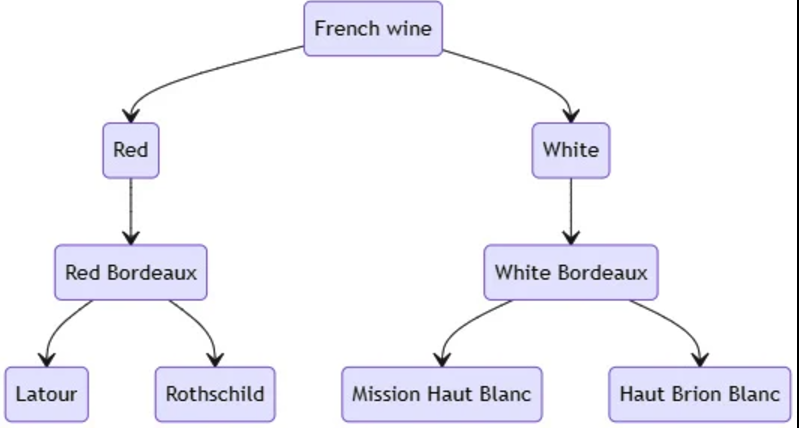

This is a very simplified of French wine hierarchy but it shows a subclass column.  
This will be clearer in a little bit. 

I imported the wine.csv file. I now need to make a table out of it:

In [38]:
shell_commd(
    """
    create or replace table wine as
    select *
    from read_csv('../data/data_in/wines.csv')
    ;
    """
)

In [40]:
shell_commd(
    """
    select *
    from wine
    order by wine_id
    ;
    """
)

┌─────────┬────────────────────┬──────────────┐
│ wine_id │     wine_name      │ sub_class_of │
│  int64  │      varchar       │    int64     │
├─────────┼────────────────────┼──────────────┤
│       1 │ French wine        │         NULL │
│       2 │ Red                │            1 │
│       3 │ White              │            1 │
│       4 │ White Bordeaux     │            3 │
│       5 │ Mission Haut Blanc │            4 │
│       6 │ Haut Brion Blanc   │            4 │
│       7 │ Red Bordeaux       │            2 │
│       8 │ Latour             │            7 │
│       9 │ Rothschild         │            7 │
└─────────┴────────────────────┴──────────────┘


The sub-class column says that the Rotschild wine is of subclass 7, which is the wine_id 7, Red Bordeaux wines. Rotschild wines are a kind of Red Bordeaux wines, which in turn are of subclass 2, Red wines, which are of subclass 1, French wines. These relationships define a hierarchy. 

To get it out from a database, DuckDB performs what is called a hierarchical traversal. 

#### **Hierarchical traversal**
Hierarchical traversal is a way to **navigate** through data organized in a **hierarchy**, and using recursion is a powerful method to solve these problems. A **recursive function** is one that **calls itself** to break a big problem **into smaller, more manageable parts**. 

In DuckDB, we can use a recursive Common Table Expression (CTE) to handle these hierarchical issues. A recursive CTE consists of two main parts:

1. **Base Case**: This is the **starting point** of your query. It defines the initial result set that the recursion will build upon.
2. **Recursive Case**: This part shows how to **combine** the current results **with the next** level of data. It continues to generate new results **until there are no more rows** left to return.

While we're focusing on using a recursive CTE to explore a hierarchy, it's also useful for other tasks such as **finding routes** between cities, checking **network conditions**, or navigating **complex paths** in nested data.

In [42]:
shell_commd(
    """
    with recursive wine_hierarchy(
        wine_id, start_with, wine_path
        )
    as(
        select
            wine_id,
            wine_name, 
            [wine_name]
        as wine_path
        from wine
        where sub_class_of is null
        union all
        select
            wine.wine_id, 
            wine.wine_name,
            list_prepend(
                wine.wine_name,
                wine_hierarchy.wine_path
                )
        from wine, wine_hierarchy
        where wine.sub_class_of = wine_hierarchy.wine_id
    )
    select wine_path
    from wine_hierarchy
    where start_with = 'Rothschild'
    ;
    """
)

┌──────────────────────────────────────────────┐
│                  wine_path                   │
│                  varchar[]                   │
├──────────────────────────────────────────────┤
│ [Rothschild, Red Bordeaux, Red, French wine] │
└──────────────────────────────────────────────┘


What is returned is the same hierarchy relationship that I wrote earlier.  

This is just one example use case of a recursive query. Some common examples of hierarchical data you might encounter include organizational structure, application menu structure, a set of tasks with sub-tasks in the project, links between web pages and a breakdown of an equipment module into parts and sub-parts.

### **Macros**:

Put simply a macro is a little piece of code that can be shared and as such used easily. 
I want to calculate the price of wines per ml (milliliter). I imported the csv file wines_price, and as usual I make a table out of it:

In [ ]:
# refactoring the code to create/replace a table from CSV:
def table_fromCSV(table_name: str, csv_file: str):    
    shell_commd(
        f"create or replace table {table_name} as select * from read_csv('../data/data_in/{csv_file}')"
    )
    
table_fromCSV("wine_prices", "wine_prices.csv")

In [55]:
shell_commd("select * from wine_prices;")

┌───────────────────┬────────┬─────────────┐
│     wine_name     │ price  │ capacity_ml │
│      varchar      │ double │    int64    │
├───────────────────┼────────┼─────────────┤
│ French Rose       │   16.5 │         750 │
│ French Pinot Noir │   17.0 │         750 │
│ Rose              │   18.4 │        1000 │
└───────────────────┴────────┴─────────────┘


This is a very  simple table, enough to show what is a macro. 

The macro is also simple:

In [56]:
shell_commd(
    """
    create or replace macro unit_price(
        price, capacity
        )
    as round(
        price / capacity,
        3
        )
    ;
    """
)

This macro is obviously a **simple division**. The number 3 sets the number of floating points, meaning it is rounded to **3 decimal places**. 

The macro is ready for use in a command: 

In [58]:
shell_commd(
    """
    select
        wine_name,
        price,
        capacity_ml,
        unit_price(
            price,
            capacity_ml)
        as price_ml
    from wine_prices
    ;
    """
)

┌───────────────────┬────────┬─────────────┬──────────┐
│     wine_name     │ price  │ capacity_ml │ price_ml │
│      varchar      │ double │    int64    │  double  │
├───────────────────┼────────┼─────────────┼──────────┤
│ French Rose       │   16.5 │         750 │    0.022 │
│ French Pinot Noir │   17.0 │         750 │    0.023 │
│ Rose              │   18.4 │        1000 │    0.018 │
└───────────────────┴────────┴─────────────┴──────────┘


---